# Fine-turn ASR based on VIVOS dataset

- Dataset: VIVOS: Vietnamese Speech Corpus for ASR
- Link: https://www.kaggle.com/datasets/kynthesis/vivos-vietnamese-speech-corpus-for-asr

## Import datasets

In [7]:
import os 
import pandas as pd
import pathlib

In [8]:
train_dir = "datasets/vivos/train"
test_dir = "datasets/vivos/test"

In [9]:
def load_audio_df(dir):
    gender_df = pd.read_csv(os.path.join(dir, "genders.txt"), 
                            sep=" ", 
                            header=None, 
                            names=["folder_name", "gender"])
    prompts_df = pd.read_csv(os.path.join(dir, "prompts.txt"), 
                            header=None, 
                            names=["prompts"])
    prompts_df["file_name"] = prompts_df["prompts"].apply(lambda x: x.split(" ")[0])
    prompts_df["text"] = prompts_df["prompts"].apply(lambda x: " ".join(x.split(" ")[1:]))
    prompts_df = prompts_df.drop(columns=["prompts"])
    
    file_data = []
    for root, directories, files in os.walk(dir):
        for file in files:
            if pathlib.Path(file).suffix == '.wav':
                file_path = os.path.join(root, file)
                file_name = file.split(".")[0]
                folder_name = file_name.split("_")[0]
                file_data.append({
                    "path": file_path,
                    "file_name": file_name,
                    "folder_name": folder_name,
                })
                
    file_df = pd.DataFrame(file_data)
    # join file_df and gender_df based on folder_name
    full_ds = pd.merge(file_df, gender_df, on="folder_name")
    full_ds = pd.merge(full_ds, prompts_df, on="file_name")
    return full_ds
    

In [10]:
train_df = load_audio_df(train_dir)
test_df = load_audio_df(test_dir)

train_df.head()

,path,file_name,folder_name,gender,text
0,datasets/vivos/train/waves/VIVOSSPK17/VIVOSSPK...,VIVOSSPK17_094,VIVOSSPK17,f,VÌ CÁI VÒNG SỐ BA QUÁ HẤP DẪN
1,datasets/vivos/train/waves/VIVOSSPK17/VIVOSSPK...,VIVOSSPK17_039,VIVOSSPK17,f,THÀNH TÍCH VÀ QUY GÁN
2,datasets/vivos/train/waves/VIVOSSPK17/VIVOSSPK...,VIVOSSPK17_178,VIVOSSPK17,f,TẤT CẢ NHỮNG THỨ XUNG QUANH BẠN
3,datasets/vivos/train/waves/VIVOSSPK17/VIVOSSPK...,VIVOSSPK17_022,VIVOSSPK17,f,LÀ SẼ XỬ LÝ CƯƠNG QUYẾT NHỮNG SAI PHẠM
4,datasets/vivos/train/waves/VIVOSSPK17/VIVOSSPK...,VIVOSSPK17_052,VIVOSSPK17,f,CUỘC THI NÀY CÓ THỂ TỔ CHỨC TRONG CẢ NƯỚC


In [11]:
train_df.shape, test_df.shape

((11660, 5), (760, 5))

### Convert to Dataset

In [12]:
# add train_df and test_df to dataset
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df)
})
ds

DatasetDict({
    train: Dataset({
        features: ['path', 'file_name', 'folder_name', 'gender', 'text'],
        num_rows: 11660
    })
    test: Dataset({
        features: ['path', 'file_name', 'folder_name', 'gender', 'text'],
        num_rows: 760
    })
})

## EDA

In [24]:
sample = ds["train"][10]
sample

{'path': 'datasets/vivos/train/waves/VIVOSSPK17/VIVOSSPK17_266.wav',
 'file_name': 'VIVOSSPK17_266',
 'folder_name': 'VIVOSSPK17',
 'gender': 'f',
 'text': 'KHÔNG SỢ THIÊN HẠ CƯỜI CHÊ CHỈ SỢ KHÔNG MÊ ĐÀN BÀ'}

In [25]:
ds["train"].features

{'path': Value(dtype='string', id=None),
 'file_name': Value(dtype='string', id=None),
 'folder_name': Value(dtype='string', id=None),
 'gender': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None)}

In [26]:
import torchaudio
from IPython.display import Audio

sig, sr = torchaudio.load(sample["path"])
print("Signal shape:", sig.shape)
print("Sample rate:", sr)

Signal shape: torch.Size([1, 56000])
Sample rate: 16000


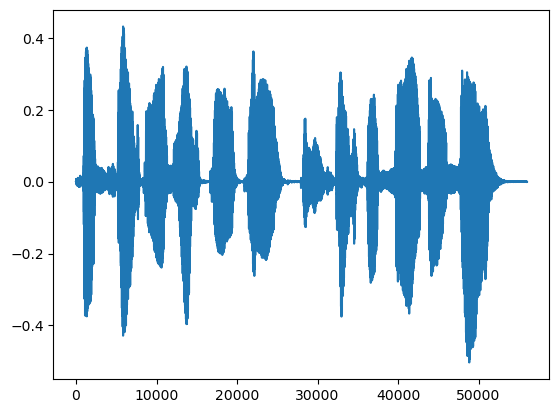

In [27]:
# Visualize the audio signal
import matplotlib.pyplot as plt
plt.figure()
plt.plot(sig[0,:])
plt.show()

In [28]:
# View audio
Audio(sig[0,:], rate=sr)

In [29]:
sample["text"]

'KHÔNG SỢ THIÊN HẠ CƯỜI CHÊ CHỈ SỢ KHÔNG MÊ ĐÀN BÀ'

## Preprocessing the dataset

In [32]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
    
    """ Load audio file into tensor
    Returns:
        (tensor, sample_rate): Return signal as a tensor and sample rate
    """
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    """
    Convert the given audio to the desired number of channels
    """
    @staticmethod
    def rechannel(audio, new_channel):
        sig, sr = audio
        
        if (sig.shape[0] == new_channel):
            # Nothing to do
            return audio
        
        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])
        
        return ((resig, sr))
    
    
    """Since Resample applies to a single channel, we resample one channel at a time"""
    @staticmethod
    def resample(audio, newsr):
        sig, sr = audio

        if (sr == newsr):
            # Nothing to do
            return audio

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))
        
    """Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds"""
    @staticmethod
    def pad_trunc(audio, max_ms):
        sig, sr = audio
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        return (sig, sr)
    
    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(audio, shift_limit):
        sig,sr = audio
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    
    
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(audio, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = audio
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    
    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec